# Twiiter nature langrage process with toolsets including tweepy, kafka, and sklearn 
1. Get twitter streaming data with keyword
2. Use producer send data to kafka server 
3. Create consumer to recive data from kafka server
4. Use nltk create feature dataframe 
5. Use PCA project nD dataframe to 2D
6. Label the reduced dataset with k mean clustering. 

### Start zookeeper and kafka server
1. bin/zookeeper-server-start.sh config/zookeeper.properties
2. bin/kafka-server-start.sh config/server.properties

In [2]:
from kafka import KafkaConsumer,KafkaProducer
import json
#import sentiment_mod as s
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream,API
from kafka import KafkaConsumer,KafkaProducer
import time

topic_2='tweepy_trump_cluster'
producer = KafkaProducer(bootstrap_servers='localhost:9092')
#Variables that contains the user credentials to access Twitter API 
access_token = "795684956026474497-YN1ga620nVYLpbl3K0G1ZbeJCcq1Fop"
access_token_secret = "nHV3V46UpzezNejnZRLVsEjd4E6rWErZmeE5PvFBFZJYK"
consumer_key = "ceL1bMzx2dsvQY0R7xhzCxTJa"
consumer_secret = "HR2lZRVMOAQ1oYvlu3Z8aB2L02DqknjDiUi3WwjCyQf0OHLnlR"


#This is a basic listener that just prints received tweets to stdout.
class myListener(StreamListener):
    def __init__(self, time_limit=60):
        self.start_time = time.time()
        self.limit = time_limit
        
    def on_data(self, data):
        time_now=time.time() - self.start_time
        if time_now < self.limit:
            #print data
            producer.send(topic_2, data.encode('utf-8'))
            return True
        else:
            print 'stop tweepy streaming'
            return False

    def on_error(self, status):
        print status


if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = myListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    myStream = Stream(auth, listener=myListener(time_limit=2))
    keyword=['trump']
    #This line filter Twitter Streams to capture data by the keywords
    myStream.filter(track=keyword)

stop tweepy streaming


In [13]:
import pandas as pd
consumer = KafkaConsumer(bootstrap_servers='localhost:9092',
                                 auto_offset_reset='earliest',
                                 consumer_timeout_ms=1000)
consumer.subscribe(topic_2)

tweet=pd.DataFrame()
tweet_text=[]
tweet_lang=[]
for msg in consumer:
    all_data = json.loads(msg.value)
    #print all_data["text"]
    tweet_text.append(all_data["text"])
    tweet_lang.append(all_data["lang"])


#tweet['text']=tweet_text
#tweet['lang']=tweet_lang
#tweet.head()

In [58]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import numpy as np
import pandas as pd
tweet_sen=reduce(lambda x,y:x+y,tweet_text)
distword = FreqDist(word.lower() for word in word_tokenize(tweet_sen))

# build feature space with the 100 most common words 
feature=[]
most=list(distword.most_common(100))
for i in range (len(most)):
    if len(most[i][0])>2:
        feature.append(most[i][0])

# build dataframe
df=pd.DataFrame()
for word in feature:
    temp=[]
    for sen in tweet_text:
        temp.append(0 if word in sen else 1)
        #temp.append(word in sen)
    df[word]=temp
    
df.head()
        



,the,https,trump,memo,that,this,and,realdonaldtrump,was,for,...,their,russia,say,think,probe,tomfitton,release,federal,state,approval
0,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,0,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
2,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,0,1,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


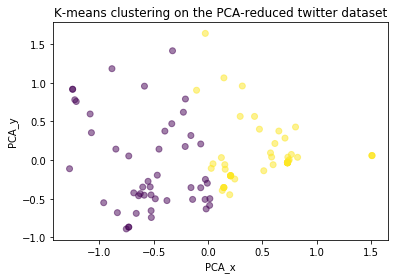

In [74]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(df)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

plt.scatter(reduced_data[:,0], reduced_data[:,1], c=kmeans.labels_, alpha=0.5)
plt.title('K-means clustering on the PCA-reduced twitter dataset')
plt.xlabel('PCA_x')
plt.ylabel('PCA_y')
plt.show()

# Future work 
1. Real time NLP
2. spark streaming 